In [1]:
## verify the python version to work with the tflite model maker
!python --version

Python 3.9.16


In [2]:
# arrange numpy dependency (<1.24) to work with tflite model maker
import numpy as np
np.version.version

'1.23.5'

In [1]:
# make sure tensorflow is installed and running on version > 2
import tensorflow as tf
assert tf.__version__.startswith('2')

2023-10-24 10:29:07.565049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 10:29:07.565063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

/home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an

In [7]:
# local dependency 
!pip3 install chardet

In [3]:
## 5 classes with RGB converted... noisy dataset
data = DataLoader.from_folder("/home/stark/thesis/sram/dataxmc/tflite-exp/dataset/noisy-5-rgb")

INFO:tensorflow:Load image with size: 505, num_label: 5, labels: board0004, board000B, board0052, board0074, board0083.


2023-10-24 10:29:17.523658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-24 10:29:17.523674: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-24 10:29:17.523685: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stark-labs): /proc/driver/nvidia/version does not exist
2023-10-24 10:29:17.523901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
## split
#train_data, rest_data = data.split(0.70)
#validation_data, test_data = rest_data.split(0.5)

train_data, test_data = data.split(0.8)


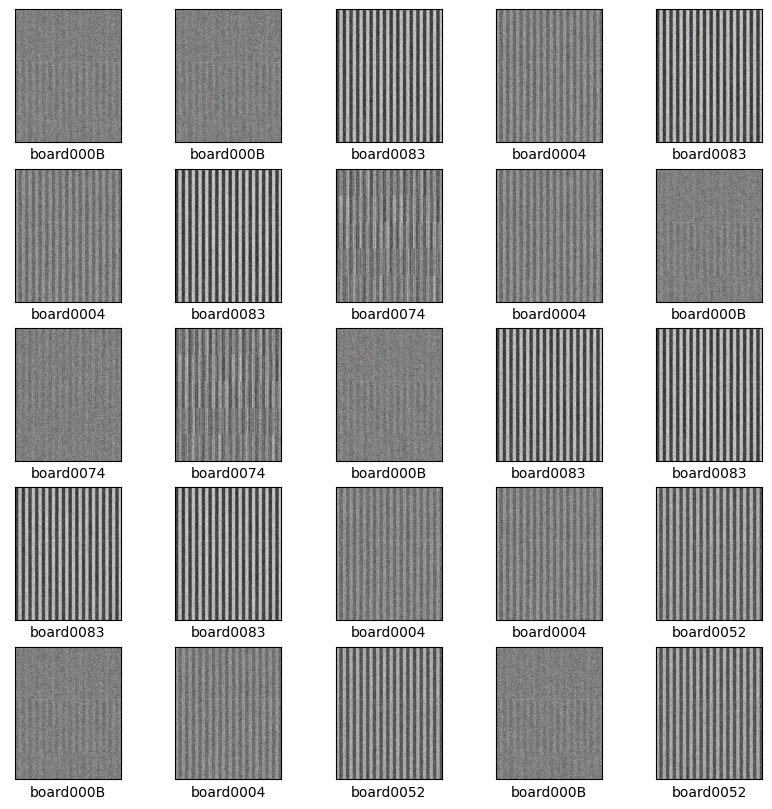

In [7]:
## show dataset with class labels
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()


In [11]:
## EfficientNet-Lite0 
model = image_classifier.create(train_data,
                                validation_data=test_data,
                                model_spec=model_spec.get('efficientnet_lite0'), 
                                learning_rate=0.0005,
                                batch_size=32,
                                dropout_rate=0.75,
                                epochs=5)


INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_3 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
12/12 [==============================] - 11s 828ms/step - loss: 2.3531 - accuracy: 0.1536 - val_loss: 1.4494 - val_accuracy: 0.5545
Epoch 2/5
12/12 [==============================] - 10s 848ms/step - loss: 1.7537 - accuracy

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________


In [11]:
loss, accuracy = model.evaluate(test_data)

3/3 [==============================] - 3s 164ms/step - loss: 0.7153 - accuracy: 0.9868


In [12]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs_range = range(5)

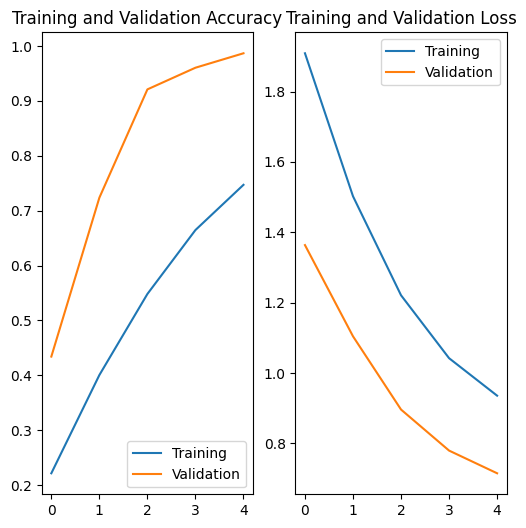

In [13]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.export(export_dir='/home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet')

2023-10-24 00:17:11.127893: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpijk4_fww/assets


INFO:tensorflow:Assets written to: /tmp/tmpijk4_fww/assets
2023-10-24 00:17:14.017170: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-10-24 00:17:14.017321: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-10-24 00:17:14.047514: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 913 nodes (656), 923 edges (664), time = 17.869ms.
  function_optimizer: function_optimizer did nothing. time = 0.011ms.

/home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-10-24 00:17:14.535613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored 

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp47z2fy3s/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp47z2fy3s/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/model.tflite


In [15]:
model.export(export_dir='/home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in /home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/labels.txt


INFO:tensorflow:Saving labels in /home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/labels.txt


In [16]:
model.evaluate_tflite('/home/stark/thesis/sram/dataxmc/tflite-exp/experiments/noisy-5/efficienetnet/model.tflite', test_data)

{'accuracy': 0.9473684210526315}